# Check GPU

In [1]:
import torch

gpu_available = torch.cuda.is_available()
print(f"GPU Available: {gpu_available}")

if gpu_available:
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU Name: {gpu_name}")

GPU Available: True
GPU Name: NVIDIA H100


# Load datasets

In [1]:
from dataset_utils import load_dataset_from_csv

ds_type = "c4op"
setting = "target-sent-target"

dataset = load_dataset_from_csv(ds_type, setting)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['doc_num', 'source_text', 'target_sentence', 'target_sentence_bertscore', 'elaboration_sentence', 'contextual_specificity_rating', 'target_sentence_4o', 'target_sentence_target'],
        num_rows: 1049
    })
    validation: Dataset({
        features: ['doc_num', 'source_text', 'target_sentence', 'target_sentence_bertscore', 'elaboration_sentence', 'contextual_specificity_rating', 'target_sentence_4o', 'target_sentence_target'],
        num_rows: 134
    })
    test: Dataset({
        features: ['doc_num', 'source_text', 'target_sentence', 'target_sentence_bertscore', 'elaboration_sentence', 'contextual_specificity_rating', 'target_sentence_4o', 'target_sentence_target'],
        num_rows: 116
    })
})


In [2]:
dataset["train"][9]

{'doc_num': 17,
 'source_text': 'Writing under the pseudonym Gul Makai ("corn flower" in Urdu, an official language of Pakistan), Malala exposed the violence and uncertainty of daily life in Swat, standing up to the Taliban\'s intimidation of ordinary people and adding a human dimension to the political and military coverage that had been the only news coming out of the Swat Valley at the time. After the Pakistani army won back control of the region, Malala put her international recognition to work, campaigning for girls\' education. But the remaining Taliban, unable to strike back against the army, picked Malala as a target for their wrath. On Oct. 9, gunmen stopped the school bus Malala was riding, asked the other children to point her out, and fired a bullet into her skull. Two other girls were wounded.',
 'target_sentence': 'But the remaining Taliban, unable to strike back against the army, picked Malala as a target for their wrath.',
 'target_sentence_bertscore': 0.527180910110473

## Check texts length

In [3]:
def count_texts_over_word_limit(dataset_dict, column, word_limit=512):
    word_count = {}

    for split in dataset_dict:
        dataset = dataset_dict[split]
        count_over_limit = 0

        for example in dataset:
            try:
                num_words = len(example[column].split()) # count on spaces
                if num_words > word_limit:
                    count_over_limit += 1
            except AttributeError as e: 
                print(f"Empty string in doc num: {example['doc_num']}")
                continue 

        word_count[split] = count_over_limit

    return word_count

In [15]:
print("Model's max length: ", tokenizer.model_max_length)

Model's max length:  1024


In [4]:
count_texts_over_word_limit(dataset, column='elaboration_sentence', word_limit=32)

{'train': 0, 'validation': 0, 'test': 0}

In [6]:
count_texts_over_word_limit(dataset, column='source_text', word_limit=512)

{'train': 0, 'validation': 0, 'test': 0}

# Load the model

In [2]:
from transformers import BartTokenizerFast, BartForConditionalGeneration, BartTokenizer
import torch
torch.cuda.empty_cache()

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base',use_fast=False, cache_dir="../models/bart/") 
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base', cache_dir="../models/bart/", device_map ={'':torch.cuda.current_device()})

#tokenizer = BartTokenizer.from_pretrained('facebook/bart-large',use_fast=False) 
#model = BartForConditionalGeneration.from_pretrained('facebook/bart-large', device_map ={'':torch.cuda.current_device()})

# Tokenize datasets

## Tokenizer

In [7]:
print('<mask>' in tokenizer.get_vocab())

True


In [4]:
from transformers import AddedToken

special_tokens_dict = {
    'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True)
}

# add the special tokens to the tokenizer
tokenizer.add_special_tokens(special_tokens_dict)

0

## Tokenize datasets

In [3]:
from dataset_utils import tokenize_dataset

tokenized_dataset, formatting_func = tokenize_dataset(dataset, ds_type, setting, tokenizer)

Map:   0%|          | 0/1049 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/116 [00:00<?, ? examples/s]

In [4]:
formatting_func(dataset["train"])[150]

'For now, no one else has taken as dramatic a step as the Nisbets. The Northwest industry is getting around the problem. Hatcheries have changed the timing of when they draw in water. Scientists installed ocean monitors that give hatchery owners a few days\' notice that conditions will be poor for rearing larvae. Growers are crushing up shells and adding chemicals to the water to make it less corrosive. Shellfish geneticists are working to breed new strains of oysters that are more resistant to low pH water. But no one thinks any of that will work forever. "I do not think people understand the seriousness of the problem," David Stick, manager of the hatchery in Hilo, said. "Ocean acidification is going to be a game-changer. target_sentence=Growers are crushing up shells and adding chemicals to the water to make it less corrosive., target_phrase=\'piles of hard black lava\''

# Set up model's configuration

## Dropout

In [6]:
model.config.dropout = 0.2
print(model.config.dropout)

0.2


# Train the model

In [8]:
num_samples = len(dataset['train'])
batch_size= 2
logging_steps = 25
print("Steps per epoch: ", num_samples//batch_size )
print("Logging steps: " ,num_samples//batch_size//logging_steps )

Steps per epoch:  524
Logging steps:  20


## Seq2Seq

In [5]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, EarlyStoppingCallback
import numpy as np
from easse.sari import corpus_sari
from sacrebleu.tokenizers.tokenizer_13a import Tokenizer13a
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from transformers import DataCollatorForSeq2Seq
import os 
# disable parallelism warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

model.train()

output_name = f"{ds_type}-{setting}"
print(output_name)

training_args = Seq2SeqTrainingArguments(
    output_dir=f"../models/bart/bart-news-ft/results/results-bart-{output_name}", 
    eval_strategy="epoch",
    save_strategy = "epoch",
    logging_strategy="steps",
    logging_steps=25,
    learning_rate=1e-5, # paper: 1e-4
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2, 
    num_train_epochs=3,
    save_total_limit=1,
    weight_decay=0.01,
    warmup_steps = 2,
    #gradient_accumulation_steps=2,
    optim = "paged_adamw_8bit",
    load_best_model_at_end=True,
    greater_is_better=False, # the lower the loss the better
    fp16=True,
    logging_dir=f"../models/bart/bart-news-ft/logs/logs-bart-{output_name}",
    predict_with_generate=True,
    metric_for_best_model='eval_loss'
)


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    #tokenizer=tokenizer,
    data_collator=data_collator,
    #compute_metrics=compute_bleu,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

model.config.use_cache = False

c4op-target-sent-target


In [6]:
trainer.train()

/home/6/ud03926/nlp/lib64/python3.9/site-packages/transformers/data/data_collator.py:657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Epoch,Training Loss,Validation Loss
1,1.174000,1.045158
2,0.975400,1.019302
3,0.883300,1.025063


/home/6/ud03926/nlp/lib64/python3.9/site-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=1575, training_loss=1.6014034416562035, metrics={'train_runtime': 82.8643, 'train_samples_per_second': 37.978, 'train_steps_per_second': 19.007, 'total_flos': 959420317040640.0, 'train_loss': 1.6014034416562035, 'epoch': 3.0})

## Training Process

In [14]:
log_history = trainer.state.log_history
eval_logs = [log for log in log_history if "eval_loss" in log]

# the best (lowest) validation loss
best_eval_log = min(eval_logs, key=lambda x: x["eval_loss"])

print(f"Best validation loss: {best_eval_log['eval_loss']}")
print(f"Epoch of the best model: {best_eval_log['epoch']}")
#print("Sari score: ", best_eval_log['eval_sari'] )

Best validation loss: 0.8764761090278625
Epoch of the best model: 3.0


In [ ]:
import json

# Path to the `trainer_state.json` file in your checkpoint directory
trainer_state_path = f"../models/bart/bart-news-ft/results/results-bart-{output_name}/checkpoint-1050/trainer_state.json"

# Open and load the JSON file
with open(trainer_state_path, "r") as file:
    trainer_state = json.load(file)

eval_logs = [log for log in trainer_state.get("log_history", []) if "eval_loss" in log]

for log in eval_logs:
    print(f"Epoch: {log.get('epoch', 'N/A')}, Step: {log.get('step', 'N/A')}, Eval Loss: {log['eval_loss']}")

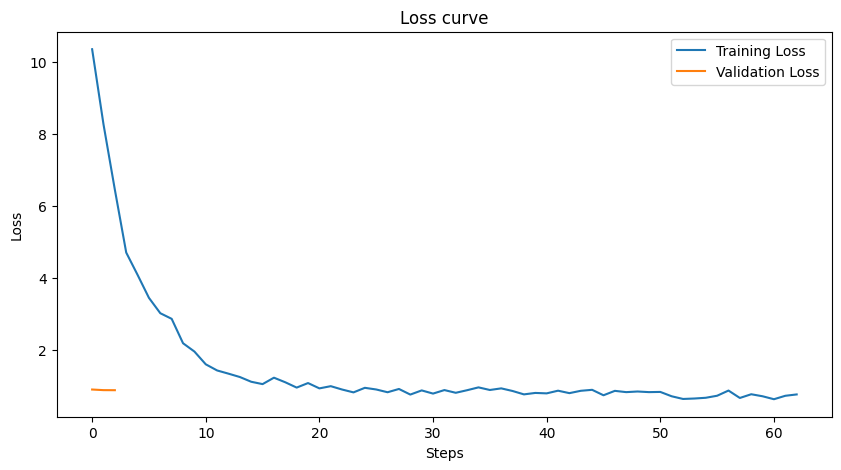

In [15]:
import matplotlib.pyplot as plt

# loss values from the log history
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
steps = range(len(train_loss))

plt.figure(figsize=(10,5))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps[:len(eval_loss)], eval_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.legend()
plt.show()

# Save model

In [22]:
generation_config.save_pretrained("../models/bart-news-ft/model-2csp")
#tokenizer.save_pretrained("../models/bart-swipe-ft/model-swipe-clean")
model.save_pretrained("../models/bart-news-ft/model-2csp")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


# Load the saved model

In [6]:
from transformers import BartForConditionalGeneration, BartTokenizer, GenerationConfig
import os

output_name = "c2s-base"
checkpoint_dir = f"../models/bart/bart-news-ft/results/results-bart-{output_name}"
# find the checkpoint number
checkpoints = [d for d in os.listdir(checkpoint_dir) if d.startswith("checkpoint-")]
if not checkpoints:
    raise FileNotFoundError(f"No checkpoints found in directory: {checkpoint_dir}")

latest_checkpoint = sorted(checkpoints, key=lambda x: int(x.split('-')[-1]))[-1]
latest_checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base',use_fast=False, cache_dir="../models/bart/")
model = BartForConditionalGeneration.from_pretrained(latest_checkpoint_path)
generation_config = GenerationConfig.from_pretrained(latest_checkpoint_path)
#model.generation_config = generation_config

# Generate predictions

In [7]:
from tqdm.notebook import tqdm
from transformers import GenerationConfig
import pandas as pd
from dataset_utils import create_results_df

model.eval()
model.config.use_cache = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


search_type = {"beam-search":{"num_beams":4, "early_stopping":True, 
                              "filename":f"../data/gen_predictions/predictions_bart-ft-{output_name}.csv"},
              "greedy":{"num_beams":1, "early_stopping":False,
                        "filename":f"../data/gen_predictions/predictions_bart-ft-{output_name}-greedy.csv"}
}

for search_t in search_type.keys():

    df_results = create_results_df(dataset)
    
    generation_config = GenerationConfig(
        bos_token_id = 0,
        decoder_start_token_id = 2,
        early_stopping = search_type[search_t]["early_stopping"], 
        do_sample = False,
        max_new_tokens = 32, # 512
        eos_token_id = 2, 
        forced_bos_token_id = 0,
        forced_eos_token_id = 2,
        no_repeat_ngram_size = 3,
        num_beams = search_type[search_t]["num_beams"], # beam search, num_beams = 1 - greedy decoding
        pad_token_id = 1,
        num_return_sequences=1
    )

    if formatting_func:
        test_dataset = formatting_func(dataset["test"])
    else:
        test_dataset = dataset["test"]["source_text"]


    with torch.no_grad(): # format_target(dataset["test"]) dataset["test"]["source_text"] format_sent_target(dataset["test"]) dataset["test"]["source_text"]
        for idx, example in tqdm(enumerate(test_dataset)):
            # tokenize the text
            input_ids = tokenizer(example, return_tensors="pt")
            # move input_ids to the same device as the model
            input_ids = {key: value.to(device) for key, value in input_ids.items()}
            
            # generate prediction
            output_ids = model.generate(**input_ids, generation_config=generation_config ) # temperature=0.45, do_sample=True
            simplified_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            df_results.at[idx,"pred_elaboration"] = simplified_text


    df_results.to_csv(search_type[search_t]["filename"], index=False)
    print(f"Saved {search_type[search_t]['filename']}")

0it [00:00, ?it/s]

Saved ../data/gen_predictions/predictions_bart-ft-c4op-target-sent-target.csv


0it [00:00, ?it/s]

Saved ../data/gen_predictions/predictions_bart-ft-c4op-target-sent-target-greedy.csv
